In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

In [12]:
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

In [2]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [3]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [4]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = './dataset'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

In [28]:
def extract_features(directory, sample_count):
    
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

    i = 0
    
    for inputs_batch, labels_batch in generator:
        
        #print( labels_batch.shape , labels_batch[0] )
        # label은 (20,)의 1차원 ndarrdy
        
        #print( inputs_batch.shape , inputs_batch[0] )
        # inputs_batch은 (20,150,150,3) ndarrdy
        
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        
        i += 1        
        if i * batch_size >= sample_count:
            # 제너레이터는 루프 안에서 무한하게 데이터를 만들어내므로 모든 이미지를 한 번씩 처리하고 나면 중지합니다
            break
    
    return features, labels

In [29]:
train_features, train_labels = extract_features(train_dir, 2000)

Found 2000 images belonging to 2 classes.


In [30]:
type( train_features )
train_features.shape
train_labels.shape
train_labels[0:10]

numpy.ndarray

(2000, 4, 4, 512)

(2000,)

array([0., 1., 0., 0., 1., 1., 0., 0., 0., 1.])

In [31]:
validation_features, validation_labels = extract_features(validation_dir, 1000)

Found 1000 images belonging to 2 classes.


In [32]:
test_features, test_labels = extract_features(test_dir, 1000)

Found 1000 images belonging to 2 classes.


In [33]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [34]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 723us/step - loss: 0.6165 - acc: 0.6515 - val_loss: 0.4434 - val_acc: 0.8260
Epoch 2/30
2000/2000 [==============================] - 1s 280us/step - loss: 0.4296 - acc: 0.8090 - val_loss: 0.3600 - val_acc: 0.8590
Epoch 3/30
2000/2000 [==============================] - 1s 276us/step - loss: 0.3520 - acc: 0.8420 - val_loss: 0.3238 - val_acc: 0.8720
Epoch 4/30
2000/2000 [==============================] - 1s 276us/step - loss: 0.3103 - acc: 0.8710 - val_loss: 0.3069 - val_acc: 0.8760
Epoch 5/30
2000/2000 [==============================] - 1s 283us/step - loss: 0.2899 - acc: 0.8870 - val_loss: 0.2848 - val_acc: 0.8920
Epoch 6/30
2000/2000 [==============================] - 1s 282

In [35]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Training and validation accuracy')

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Training and validation loss')

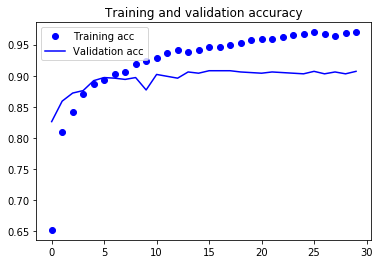

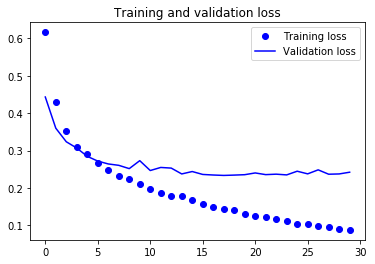

In [36]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [9]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [11]:
print('conv_base를 동결하기 전 훈련되는 가중치의 수:', 
      len(model.trainable_weights))

conv_base를 동결하기 전 훈련되는 가중치의 수: 30


In [12]:
conv_base.trainable = False

In [13]:
print('conv_base를 동결한 후 훈련되는 가중치의 수:', 
      len(model.trainable_weights))

conv_base를 동결한 후 훈련되는 가중치의 수: 4


In [14]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest')

# 검증 데이터는 증식되어서는 안 됩니다!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지의 크기를 150 × 150로 변경합니다
        target_size=(150, 150),
        batch_size=20,
        # binary_crossentropy 손실을 사용하므로 이진 레이블이 필요합니다
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
 - 14s - loss: 0.5165 - acc: 0.7575 - val_loss: 0.4247 - val_acc: 0.8170
Epoch 2/30
 - 13s - loss: 0.3989 - acc: 0.8325 - val_loss: 0.3414 - val_acc: 0.8620
Epoch 3/30
 - 12s - loss: 0.3424 - acc: 0.8625 - val_loss: 0.3006 - val_acc: 0.8740
Epoch 4/30
 - 13s - loss: 0.3187 - acc: 0.8645 - val_loss: 0.2791 - val_acc: 0.8880
Epoch 5/30
 - 13s - loss: 0.2934 - acc: 0.8775 - val_loss: 0.2657 - val_acc: 0.8940
Epoch 6/30
 - 13s - loss: 0.2779 - acc: 0.8885 - val_loss: 0.2561 - val_acc: 0.8990
Epoch 7/30
 - 12s - loss: 0.2802 - acc: 0.8830 - val_loss: 0.2554 - val_acc: 0.8970
Epoch 8/30
 - 12s - loss: 0.2572 - acc: 0.8970 - val_loss: 0.2518 - val_acc: 0.9000
Epoch 9/30
 - 12s - loss: 0.2544 - acc: 0.8955 - val_loss: 0.2613 - val_acc: 0.8860
Epoch 10/30
 - 12s - loss: 0.2422 - acc: 0.9035 - val_loss: 0.2398 - val_acc: 0.9050
Epoch 11/30
 - 12s - loss: 0.2439 - acc: 0.8935 - val_loss: 0.2417 - val_ac

In [15]:
model.save('cats_and_dogs_small_3.h5')

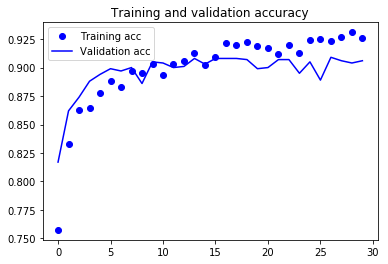

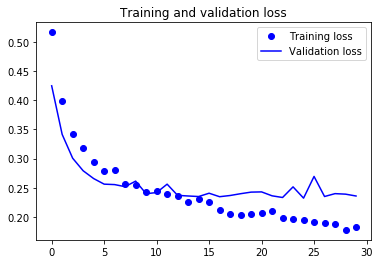

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [17]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [18]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [19]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 14s 137ms/step - loss: 0.1813 - acc: 0.9255 - val_loss: 0.2593 - val_acc: 0.9000
Epoch 2/100
100/100 [==============================] - 13s 128ms/step - loss: 0.1533 - acc: 0.9430 - val_loss: 0.2473 - val_acc: 0.9080
Epoch 3/100
100/100 [==============================] - 13s 128ms/step - loss: 0.1373 - acc: 0.9450 - val_loss: 0.2697 - val_acc: 0.8930
Epoch 4/100
100/100 [==============================] - 13s 128ms/step - loss: 0.1190 - acc: 0.9535 - val_loss: 0.2574 - val_acc: 0.9010
Epoch 5/100
100/100 [==============================] - 13s 128ms/step - loss: 0.0953 - acc: 0.9655 - val_loss: 0.1973 - val_acc: 0.9250
Epoch 6/100
100/100 [==============================] - 13s 128ms/step - loss: 0.0770 - acc: 0.9705 - val_loss: 0.2241 - val_acc: 0.9260s - loss:  - ETA: 3s - loss: 0.0793 - acc: - ETA: 2s - loss: 0.0859 - acc:  - ETA: 2s - loss: 0.0853 - acc:  - ETA: 1s - loss: 0.0
Epoch 7/100
100/100 [==============================] -

In [20]:
model.save('cats_and_dogs_small_4.h5')

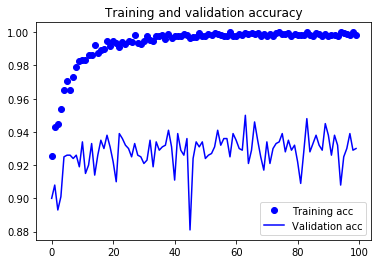

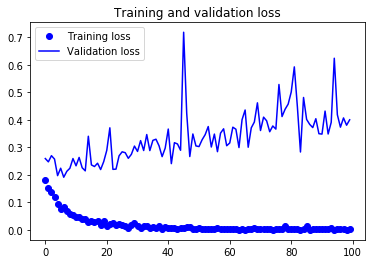

In [21]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [22]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.9409999907016754
